# Analyse data for line loop navigation coming from the homecage 

In [1]:
%matplotlib inline

import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
import scipy.stats as stt
import pandas as pd
from datetime import datetime, timedelta
from functools import partial
import matplotlib
import networkx as nx
import copy as cp
import seaborn
from scipy.ndimage import gaussian_filter1d


In [2]:
cmap_ = 'RdYlGn'
cmap = matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=0,vmax=0.6,clip=True),cmap=cmap_)
seaborn.set(font_scale=1.5,style='ticks')

#physical positions of the pokes
poke_pos = np.array([1,-1])*np.array([ [149,0],
         [68,19],[231,19],
       [0,62],[149,62],[298,62],
         [68,105],[231,105],
              [149,124]])

##  Main function to analyse probe trial performance

In [3]:
def get_experiment_name(line):
    return re.findall('Experiment name[\s] \: (.*)\n',line)[0]

def get_subject_name(line):
    return re.findall('Subject ID[\s]:[\s](.*)\n',line)[0]

def get_start_date(line):
    return re.findall('Start date[\s]:[\s](.*)\n',line)[0]

In [4]:
def get_probe_trial_performance_homecage(lines,fpath,MIN_REW_IN_SEQ=50):

    """ 
        Takes in lines output by pycontrol and returns a dict that contains probe trial
        performance for each transition
    
    
        Arguments:
        ===========================
        lines (list of str):             output of pycontrol
        
        Returns:
        ==========================
        all_info_dicts (list of dicts):  a list of dicts where each entry in the list
                                         is a dict containing whether probe trial\s were
                                         correct for each transition. If more than 1 graph
                                         was explored in a given session, then the performance
                                         then this list will have more than 1 dict in it. Other
                                         wise it will only have one
        
        
    """
    times = []
    probe_perf = []
    probe_target = []
    probe_from = []
    probe_to = []
    probe_transition = []
    target_hist = []; probe_hist = []; poked_hist = []; dir_hist = []; seq_hist = []

    task_nums = []
    info_dict = {'fpath': fpath}
    probe_dict = {}
    all_info_dicts = [] #this is for when there are two tasks in one session
    seq = None
    task_number = None
    graph_type = None
    n_rewards = np.nan
    full_sequences = None
    #iterate over flines
    
    probe_start = -100000
    hasrunprobe = True
    
    
    try:
        probe_dur = float(eval(re.findall('Variables(.*)',lines[-1])[0])['probe_dur'])
    except IndexError:
        probe_dur = 2000.

    try:
        n_rew_tot = float(eval(re.findall('Variables(.*)',lines[-1])[0])['n_rewards'])
    except IndexError:
        n_rew_tot = 0
    rew_in_seq = 0
    if n_rew_tot>10:
        for ix,l_ in enumerate(lines[:-1]):


            #find basic task metadata
            if 'Subject ID' in l_: info_dict['subject'] = get_subject_name(l_)
            if 'Experiment name' in l_: info_dict['exp_name'] = get_experiment_name(l_)
            if 'Start date' in l_: info_dict['date'] = get_start_date(l_)

                

            if 'task_number' in l_:

                #if there is already one task then store the info for the
                #'completed' task here and perform some cleanup
                if len(task_nums)>0:
                    info_dict['seq'] = seq
                    info_dict['task_nr'] = task_number
                    info_dict['probe_dict'] = probe_dict.copy()
                    info_dict['len_seq'] = None if seq is None else len(seq)
                    info_dict['graph_type'] = graph_type
                    all_info_dicts.append(info_dict.copy())
                    info_dict = info_dict.copy()
                    del info_dict['probe_dict']
                    probe_dict = {}
                task_number = int(re.findall('task_number([0-9])',l_)[0])
                task_nums.append(task_number)

            #store the sequence that was explored
            if 'seq' in l_:
                seq = eval(re.findall('seq:(\[.*\])', l_)[0])

            if 'graph_type' in l_:
                graph_type = re.findall('graph_type:(.*)\n',l_)[0]
            #process the print-lines that describe the subjects behaviour
            
            
            if rew_in_seq>MIN_REW_IN_SEQ:
                if 'probe_start' in l_:
                    probe_start = float(re.findall('P ([0-9]*)',l_)[0])
                    hasrunprobe = False


            
            if 'TARGET:' in l_:  
                t_ = re.findall('P ([0-9]*) R',l_)[0]
                times.append(float(t_))
                probe = eval(re.findall('PROBE: (False|True)',l_)[0])
                target = int(re.findall('TARGET: ([0-9]*)',l_)[0])
                poked = int(re.findall('POKED: ([0-9]*)',l_)[0])
                direction = int(re.findall('DIR: (.*)',l_)[0])
                seq_ix = int(re.findall('SEQ_IX: ([0-9]*)',l_)[0])
                try:
                    rew_in_seq = int(re.findall('REW_IN_SEQ:([0-9]*)',l_)[0])
                except IndexError:
                    rew_in_seq = 99
                    
                if seq_hist:
                    if probe:  #if it is flagged as a probe trial
                        if not hasrunprobe:   #and this probe trial has not been counted
                            if rew_in_seq>MIN_REW_IN_SEQ:
                                
                                prev_target = None
                                pt_ctr = 1
                                while prev_target is None:
                                    if target_hist[-pt_ctr]!=target:
                                        prev_target = target_hist[-pt_ctr]
                                    pt_ctr+=1
                                    

                                if ((times[-1]-probe_start)<probe_dur):
                                    if poked==prev_target:
                                        pass
                                    else:
                                        hasrunprobe = True
                                        correct_poke = poked==target
                                        probe_perf.append(correct_poke)
                                        probe_to.append(poked)
                                        probe_target.append(target)
                                        probe_from.append(prev_target)
                                        transition = str(prev_target) + '_' + str(target)
                                        probe_transition.append(transition)
                                        

                                        if transition in probe_dict.keys():
                                            probe_dict[transition].append(correct_poke)
                                        else:
                                            probe_dict[transition] = [correct_poke]
                                else:
                                    #pass
                                    hasrunprobe = True
                                    correct_poke = False
                                    probe_perf.append(correct_poke)
                                    transition = str(prev_target) + '_' + str(target)

                                    if transition in probe_dict.keys():
                                        probe_dict[transition].append(correct_poke)
                                    else:
                                        probe_dict[transition] = [correct_poke]


                target_hist.append(target); probe_hist.append(probe); dir_hist.append(direction);
                poked_hist.append(poked); seq_hist.append(seq_ix)
        #print(len(probe_perf))
        try:
            n_rewards = float(eval(re.findall('Variables(.*)',lines[-1])[0])['n_rewards'])
            full_sequences = (eval(re.findall('Variables(.*)',lines[-1])[0])['sequences'])
        except IndexError:
            n_rewards = np.nan

        info_dict['seq'] = seq; info_dict['task_nr'] = task_number; info_dict['probe_dict'] = probe_dict.copy()
        info_dict['len_seq'] = None if seq is None else len(seq)
        info_dict['n_rewards'] = n_rewards
        info_dict['graph_type'] = graph_type
        info_dict['full_sequences'] = full_sequences
        info_dict['probe_target'] = probe_target
        info_dict['probe_from'] = probe_from
        info_dict['probe_to'] = probe_to
        info_dict['probe_transition'] = probe_transition
        
        all_info_dicts.append(info_dict)
    return all_info_dicts

In [5]:
def build_follow_the_light_probe_df(subject_folders):
    """
    Here we loop through the subject folders and get a list of all sessions
    that is annotated with some metadata
    
    Arguments:
    =========================================
    
    subject_folders (list): list of folders where each folder contains the
                            data files for one subject
                            
    
    """
    df = pd.DataFrame(columns=['subject','exp_name', 'date', 'seq', 'task_nr', 'probe_dict', 'len_seq','n_rewards','graph_type','sess_dur','full_sequence','fpath'])
    for ROOT in subject_folders:
        #print(ROOT)
        fs = [i for i in os.listdir(ROOT) if '_taskFile' not in i]
        probe_dict = {}
        for f_ in fs:
            if 'follow_the_light_2_graphs' in f_:
                #print(f_)
                fpath = os.path.join(ROOT,f_)
                with open(fpath,'r') as f:
                    lines = f.readlines()

                all_info_dict = get_probe_trial_performance_homecage(lines,fpath=fpath)
                #print(probe_dict)
                for i in all_info_dict:
                    df = df.append(i,ignore_index=True)
    return df, lines

In [6]:
# def merge_probe_trial_dicts(x,only_last=None):
#     """ 
#     Function passed as argument to result of pandas groupby in
#     order to merge the dicts by subject and task
    
#     Arguments:
#     =========================
#     x: what is passed by agg
    
#     only_last (int): only look at the last n probe trials for each transition
#     """
#     out = {}
#     for d in x.dropna():
#         for k,v in d.items():
#             if k not in out.keys():
#                 out[k] = v.copy()
#             else:
#                 out[k].extend(v)
                
#     if only_last:
#         for k,v in out.items():
#             out[k] = v[-only_last:]
#     return out


In [7]:
# def make_plot(res_dict,mx=1,color='mean'):
#     #plt.figure(figsize=(12,4))


# #    mx = 1
#     if color=='pval': cmap_ = 'RdYlGn_r'
#     else: cmap_ = 'RdYlGn'
#     cmap = matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=0,vmax=mx,clip=True),cmap=cmap_)

#     G0 = nx.DiGraph()
#     G0.add_nodes_from(range(9),pos=np.array([1,-1])*poke_pos,color='.3')
#     nx.draw(G0,pos=poke_pos,alpha=.2,node_color='.3')


#     G = nx.DiGraph()
#     for k,v in res_dict.items():
#         if color=='pval':
#             c = stt.binom_test(np.sum(v),len(v),p=1/8.,alternative='greater')
#         else:
#             c= np.mean(v)
#         G.add_edge(int(k[0]),int(k[-1]),color=cmap.to_rgba(c))

#     colors = nx.get_edge_attributes(G,'color')

#     nx.draw(G,
#             pos=poke_pos,edge_color=np.array(list(colors.values())),
#             node_color='.3',
#             node_size=512,
#             connectionstyle="arc3,rad=-0.1",
#             width=3
#     )
#     #plt.colorbar()

In [8]:
def get_all_transition(seq,graph_type):
    """
    What is says on the tin. Returns a list of strings describing transitions that
    is analogous to what is stored in dataframe obtained by running build_df
    """
    all_transitions = []
    lseq = len(seq)
    if graph_type=='line': s2 = seq[:-1]
    else: s2 = seq
    for kk,pk in enumerate(s2):
        #print(1)
        all_transitions.append(str(pk) + '_' + str(seq[(kk+1)%lseq]))
        if graph_type=='line':
            all_transitions.append(str(seq[(kk+1)%lseq]) + '_' + str(pk))

    if graph_type=='loop':
        for kk,pk in enumerate(s2[::-1]):
            all_transitions.append(str(pk) + '_' + str(seq[::-1][(kk+1)%lseq]))
    return all_transitions

In [221]:
def make_josh_plot(map_df,column,mx=1,color='mean',less_than_q=1):
    #plt.figure(figsize=(12,4))
    transition_test = column
    
    if color=='pval': cmap_ = 'RdYlGn_r'
    else: cmap_ = 'RdYlGn'
    cmap = matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=0,vmax=mx,clip=True),cmap=cmap_)

    #Fills graph
    G = nx.DiGraph()
    for row in map_df.index:
        c = (map_df.at[row,transition_test])/max(map_df[transition_test])
        if map_df.at[row,transition_test] < less_than_q: G.add_edge(int(transition_test[0]),int(row),color='w')
        else: G.add_edge(int(transition_test[0]),int(row),color=cmap.to_rgba(c))
    colors = nx.get_edge_attributes(G,'color')

    #makes graph correct shape
    nx.draw(G,
            pos=poke_pos,edge_color=np.array(list(colors.values())),
            node_color='.3',
            node_size=512,
            connectionstyle="arc3,rad=-0.1",
            width=3
    )

In [239]:
#is it ok to do this?
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)                  


def show_mistakes(subject_name,task_nr,min_rew,r_len_seq,less_than_p=0,reorder=True):
    df1 = df[(df['n_rewards']>min_rew)\
        & (df['subject']==subject_name)\
        & (df['task_nr']==task_nr)\
        & (df['len_seq']==r_len_seq)\
        & (df['probe_dict']!={})\
        & (df['date']>(datetime.now()-timedelta(days=15)))]
    if df1.empty is False:
        sequence = df1['seq'].values[0]
        graph_t = df1['graph_type'].values[0]
        first_row = df1.index[0]

        transitions = get_all_transition(sequence,graph_t)
        map_df = pd.DataFrame(0, index=np.arange(r_len_seq),columns=transitions)

        if reorder is True:
            map_df = map_df.reindex(sorted(map_df.columns), axis=1)

        for session in df1.index:
            for transition in map_df.columns:
                trans_ind = np.where(np.asarray(df.at[session,'probe_transition'])==transition)[0] #get indices of each time it was meant to do this transitiion 
                where_to = np.asarray(df.at[session,'probe_to'])[trans_ind] #get where it went for each time it was meant to do this transition

                for where_to_ind in where_to:
                    map_df.loc[[where_to_ind],[transition]] = map_df.loc[[where_to_ind],[transition]]+1

        #map_df.style.background_gradient(cmap='Blues',axis = None)

        plt.figure(figsize=(32,8))
        ctr = 0
        subplot_pos = [val+1 for pair in zip(range(10), range(10,20)) for val in pair]

        for column in map_df.columns:
            plt.subplot(2,10,subplot_pos[ctr])
            plt.title(column+' : '+str(sum(map_df[column])))
            make_josh_plot(map_df,column,less_than_q=less_than_p)

            ctr+=1

        print(graph_t,':',sequence,
              '\nnumber of sessions: ' + str(len(df1)),
             '\n'+subject)
        plt.show()
    
    else:
        print("\n\n\nSubject:"+graph_t+' '+subject+": DF IS EMPTY\n\n\n")


# Run analysis

In [9]:
df = pd.DataFrame(columns=['subject','time','seq','graph_type','two_tasks','nRews','probe_dict','probe_from'
                          'probe_target','probe_to'])

In [10]:
all_mice_csv = pd.read_csv('/Users/joshuakeeling/Dropbox/pyhomecage/mice/mice.csv')


In [11]:
all_data = []
for ix,row in all_mice_csv.iterrows():
    if 'ec_lineloop' in row['Experiment'] and not pd.isnull(row['set_variables']):
        tmp = [row['Mouse_ID'],
               eval(eval(row['set_variables'])['v.len_seqs'])]
        all_data.append(tmp)
    

KeyError: 'v.len_seqs'

In [12]:
all_data

[['C00494062_1', [9, 9]],
 ['C00494062_2', [9, 9]],
 ['C00494062_3', [9, 9]],
 ['C00494062_4', [9, 9]],
 ['C00494062_5', [9, 9]],
 ['C00499495_1', [9, 9]]]

In [13]:
np.mean([i[1] for i in all_data],axis=0)

array([9., 9.])

In [14]:
experiment_folders = ['/Users/joshuakeeling/Dropbox/pyhomecage/data/ec_lineloop_1/',
                     '/Users/joshuakeeling/Dropbox/pyhomecage/data/ec_lineloop_2/']

subject_folders = []
for ef in experiment_folders:
    sf1 = os.listdir(ef)
    
    for sf_ in sf1:
        sf = os.path.join(ef,sf_)
        #print(sf)
        #if sf=='/Users/yves/Downloads/ec_lineloop_2/.DS_Store':
        #|print('.DS' in sf)
        if not ('.DS' in sf):
            fold2 = [i for i in os.listdir(sf) if '.DS' not in i][0]
            subject_folders.append(os.path.join(sf,fold2))


In [15]:
df,lines = build_follow_the_light_probe_df(subject_folders)
df['date'] = pd.to_datetime(df['date'])
df = df.loc[df['n_rewards']>1]
df = df.sort_values('date')
if 'old_df' not in locals():
    old_df = cp.deepcopy(df)
    
df.to_csv('tmp.pd')

line : [3, 6, 1, 8, 4, 5, 7, 2, 0] 
number of sessions: 13 
C00499495_5


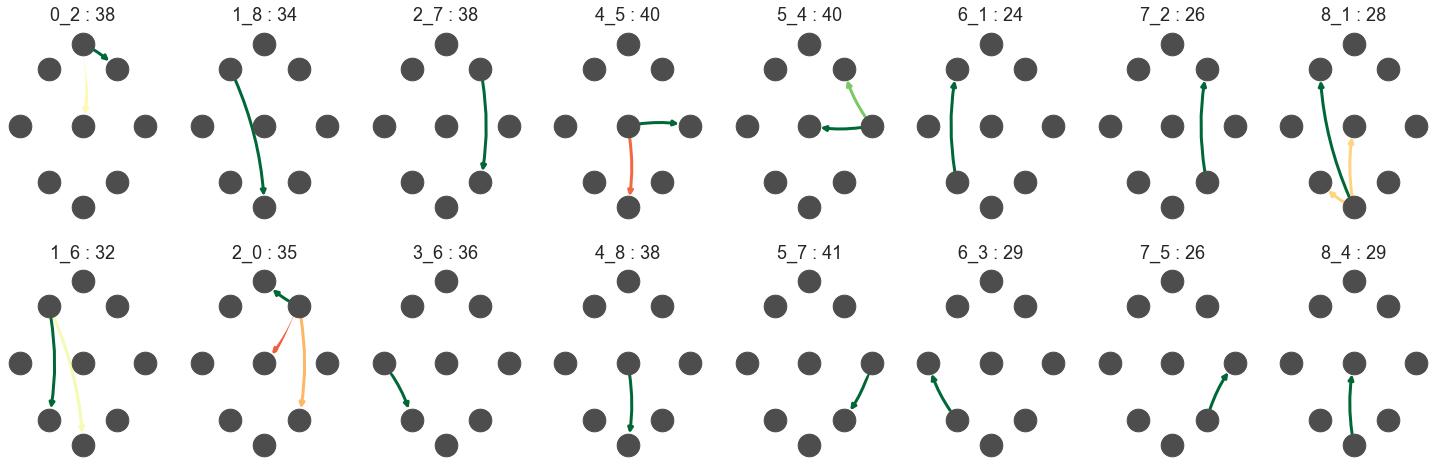

<ipython-input-221-4b0f35f051b5>:12: RuntimeWarning: invalid value encountered in long_scalars
  c = (map_df.at[row,transition_test])/max(map_df[transition_test])


line : [7, 0, 4, 5, 2, 6, 8, 1, 3] 
number of sessions: 1 
C00499495_5


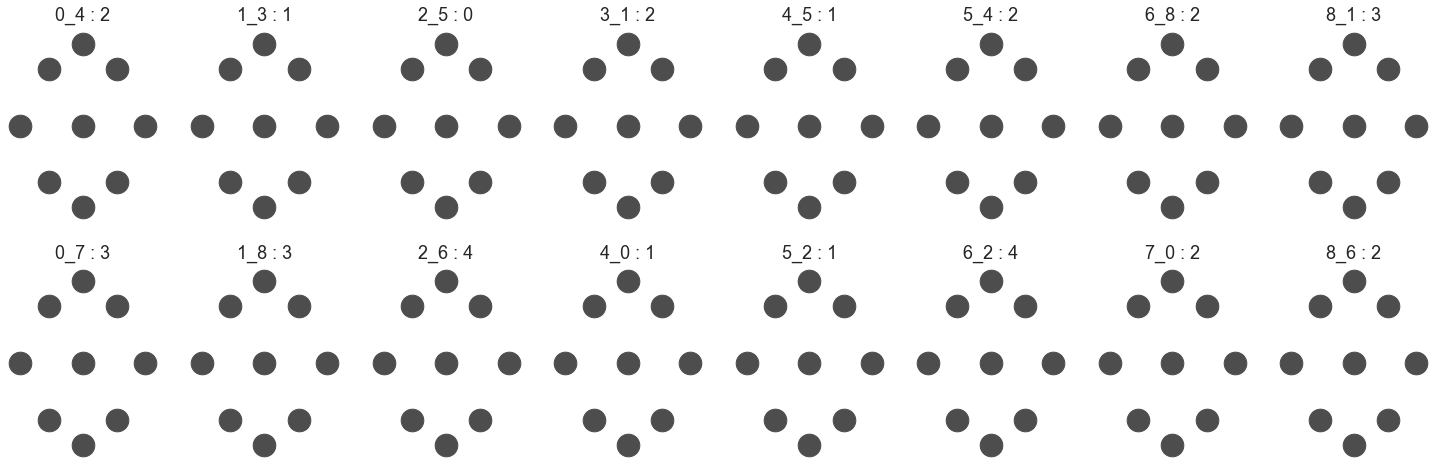

line : [3, 6, 1, 8, 4, 5, 7, 2, 0] 
number of sessions: 34 
C00499495_3


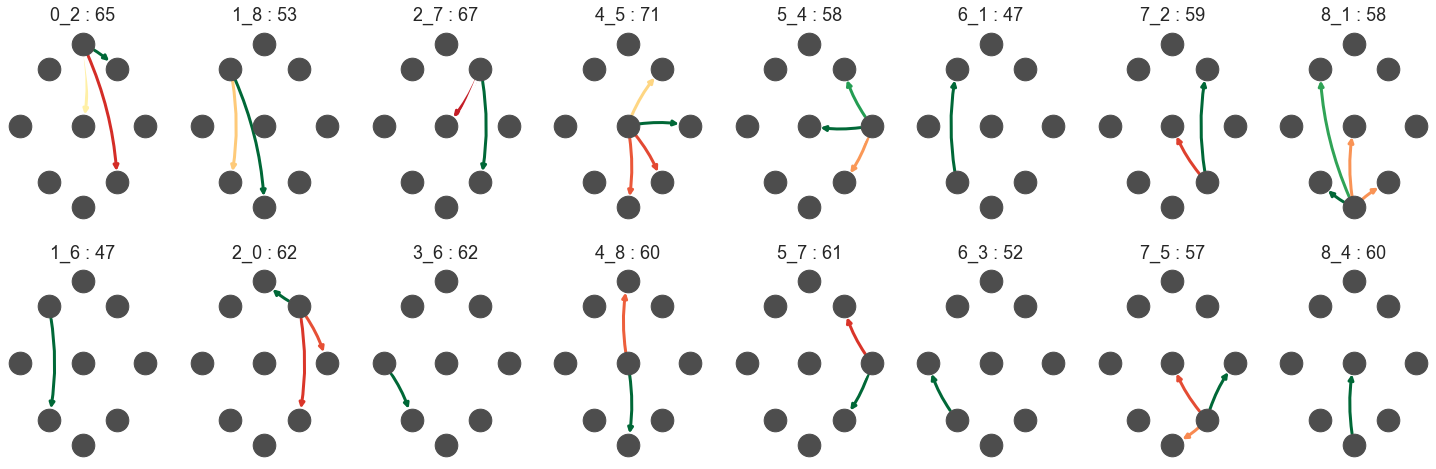

loop : [7, 0, 4, 5, 2, 6, 8, 1, 3] 
number of sessions: 5 
C00499495_3


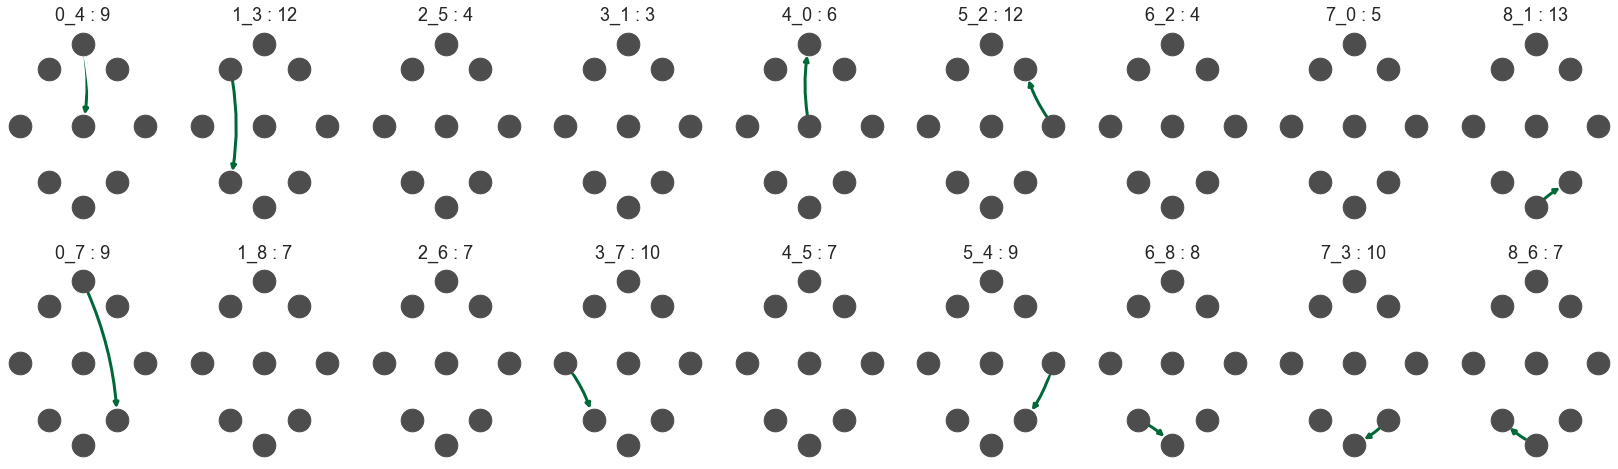

loop : [8, 4, 2, 5, 7, 0, 6, 1, 3] 
number of sessions: 12 
C00499495_1


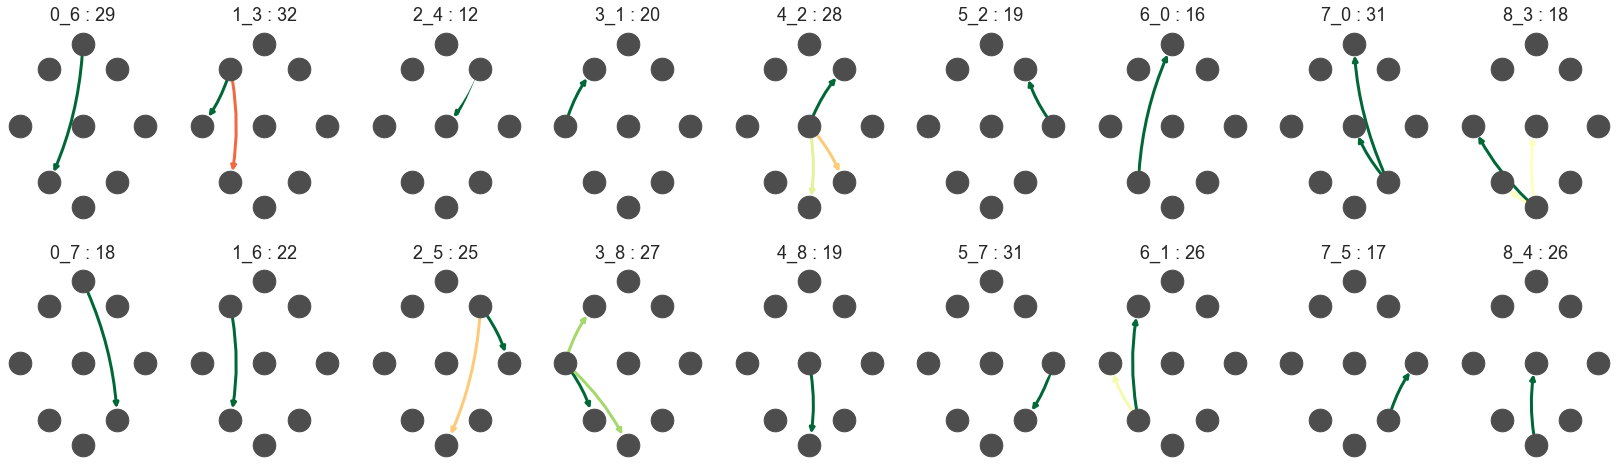

loop : [1, 3, 6, 0, 2, 8, 4, 7, 5] 
number of sessions: 28 
C00499495_1


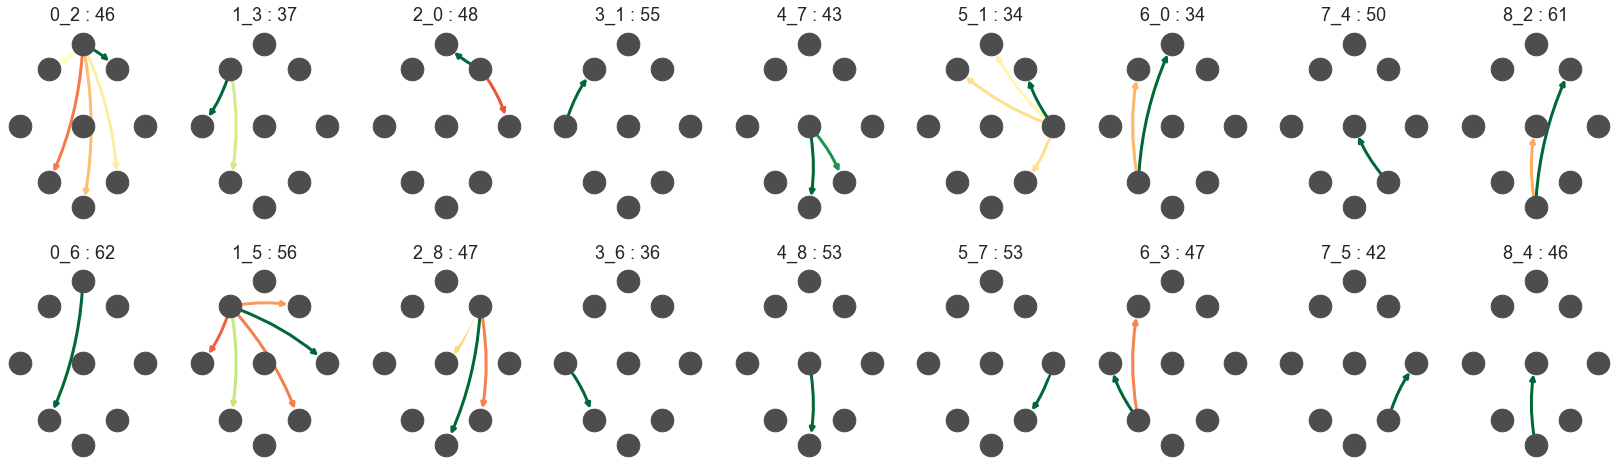

line : [8, 4, 2, 5, 7, 0, 6, 1, 3] 
number of sessions: 2 
C00494062_3


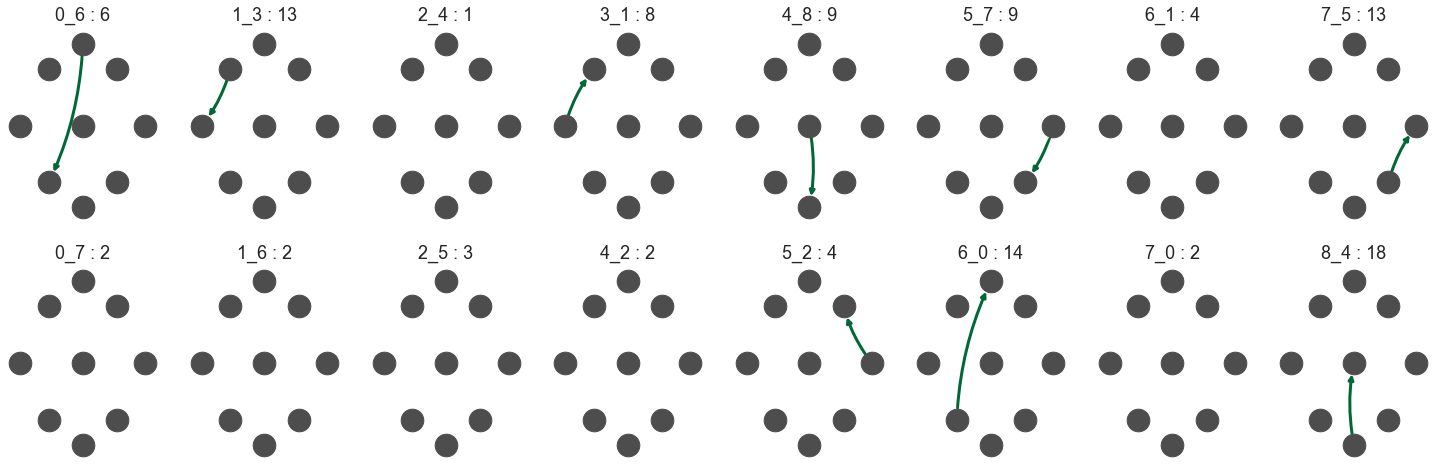

loop : [1, 3, 6, 0, 2, 8, 4, 7, 5] 
number of sessions: 32 
C00494062_3


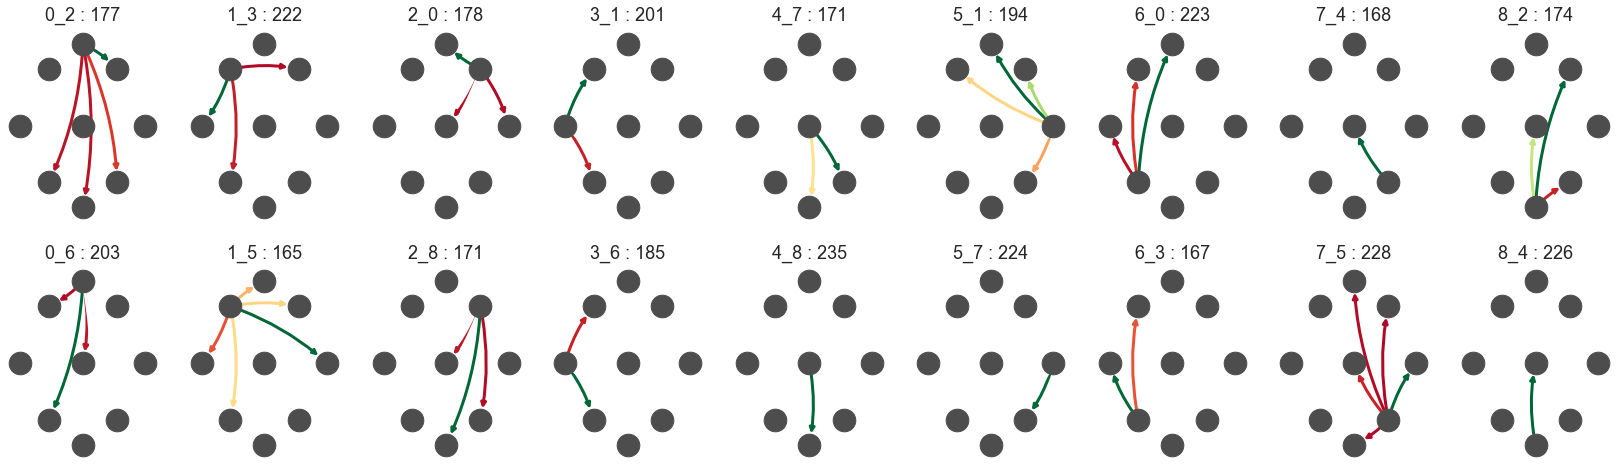

loop : [8, 1, 6, 3, 4, 0, 7, 2, 5] 
number of sessions: 20 
C00494062_2


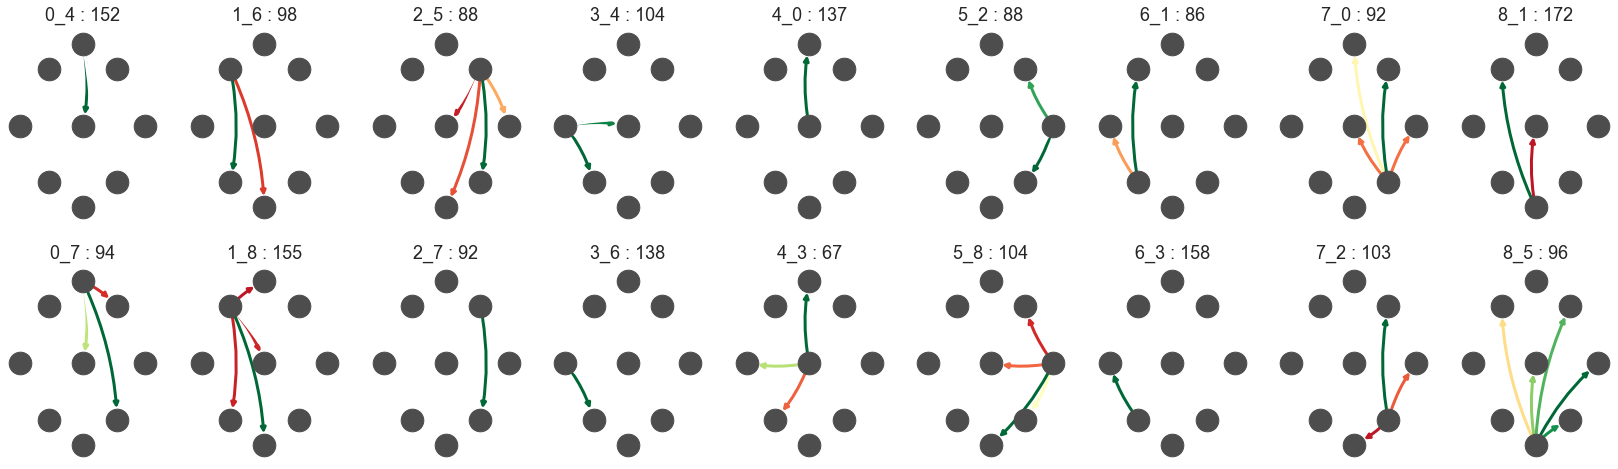

loop : [0, 4, 5, 7, 1, 8, 2, 3, 6] 
number of sessions: 45 
C00494062_2


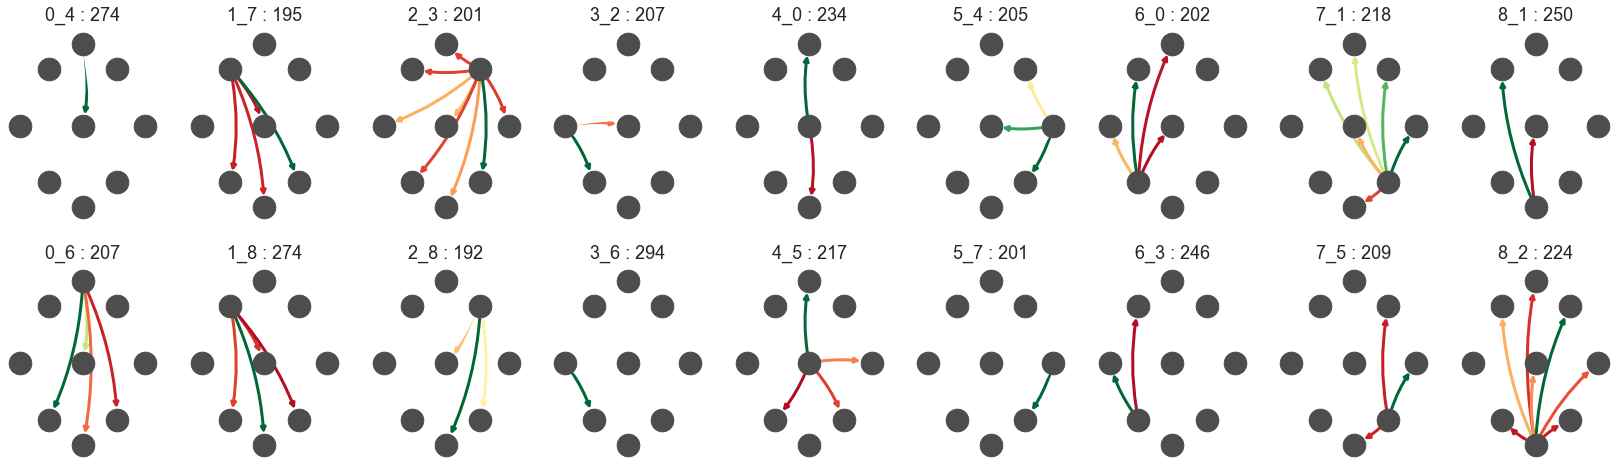

loop : [3, 6, 1, 8, 4, 5, 7, 2, 0] 
number of sessions: 17 
C00499495_6


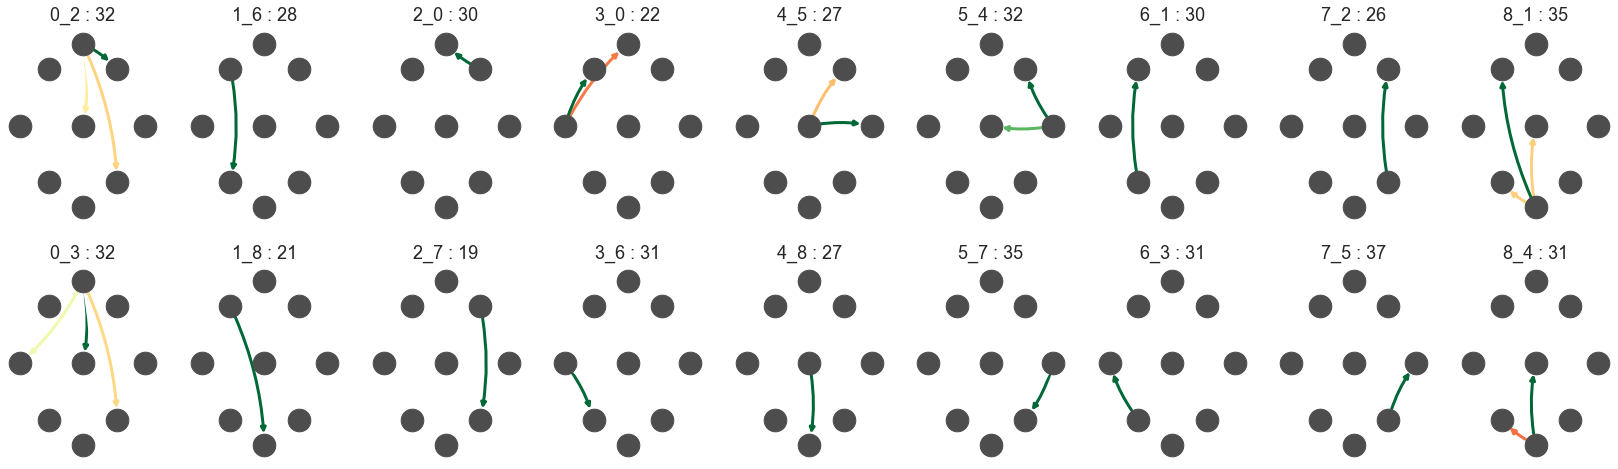

<ipython-input-221-4b0f35f051b5>:12: RuntimeWarning: invalid value encountered in long_scalars
  c = (map_df.at[row,transition_test])/max(map_df[transition_test])


loop : [7, 0, 4, 5, 2, 6, 8, 1, 3] 
number of sessions: 3 
C00499495_6


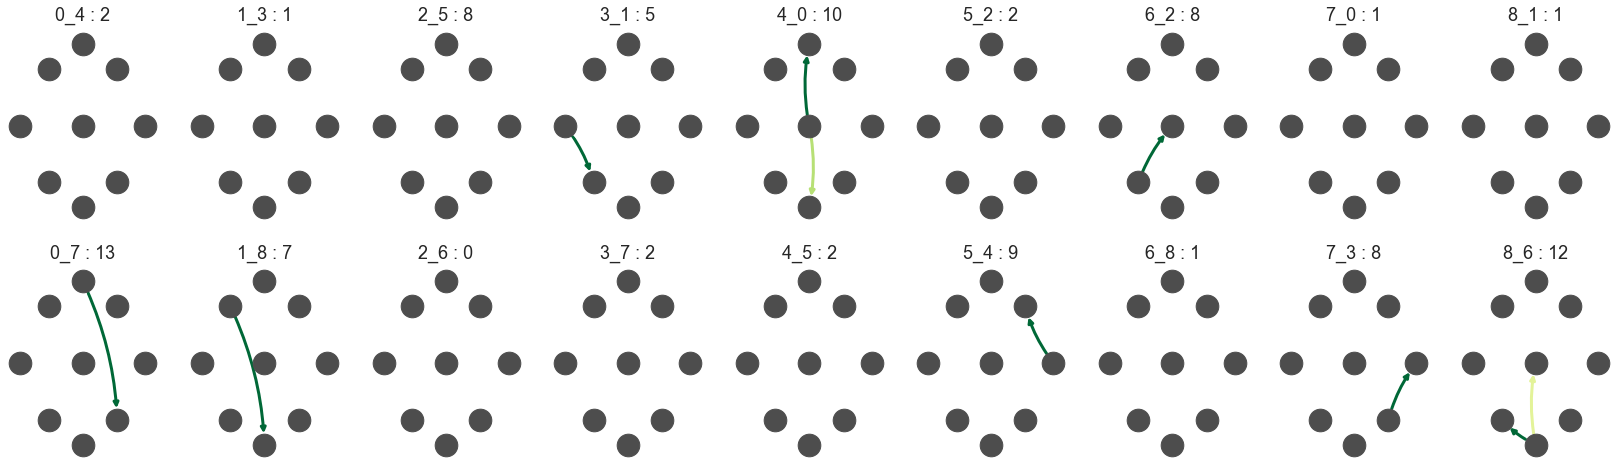




DF IS EMPTY



line : [0, 4, 5, 7, 1, 8, 2, 3, 6] 
number of sessions: 29 
C00494062_1


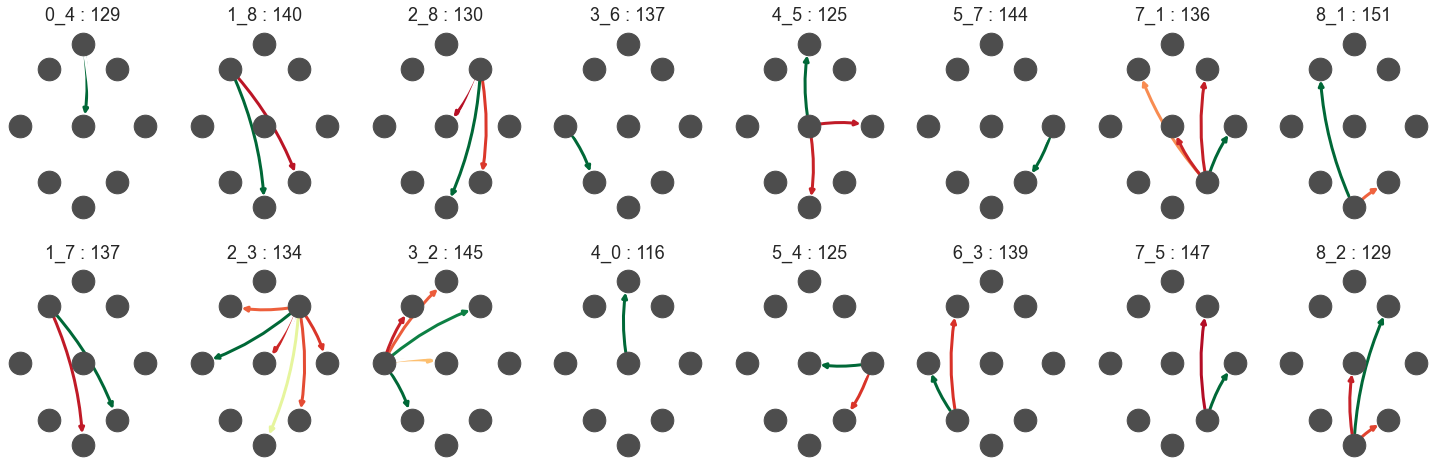

line : [8, 1, 6, 3, 4, 0, 7, 2, 5] 
number of sessions: 8 
C00494062_4


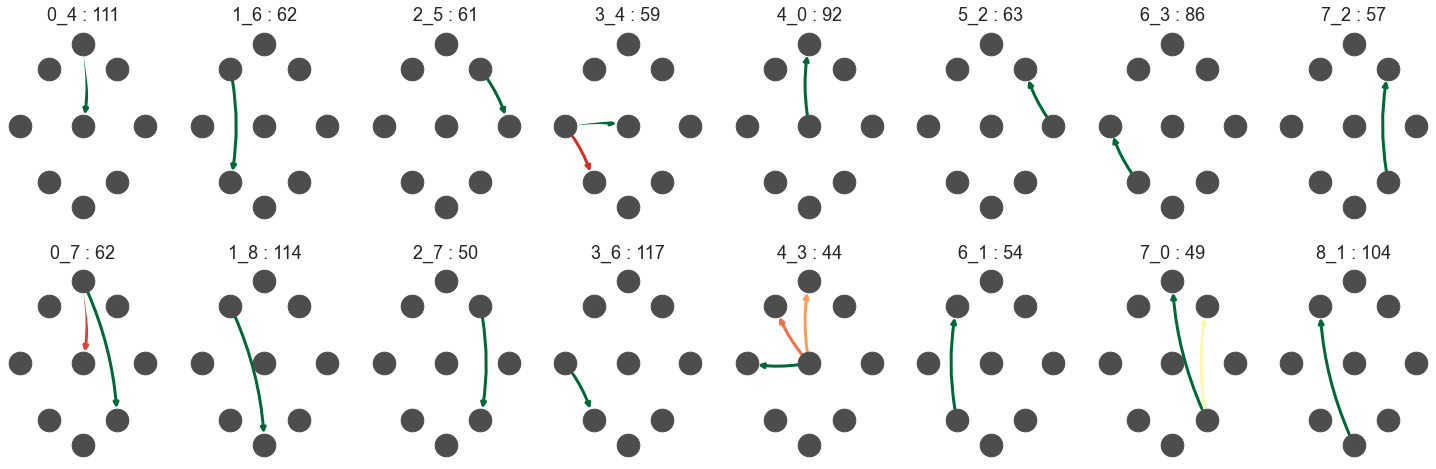

loop : [0, 4, 5, 7, 1, 8, 2, 3, 6] 
number of sessions: 25 
C00494062_4


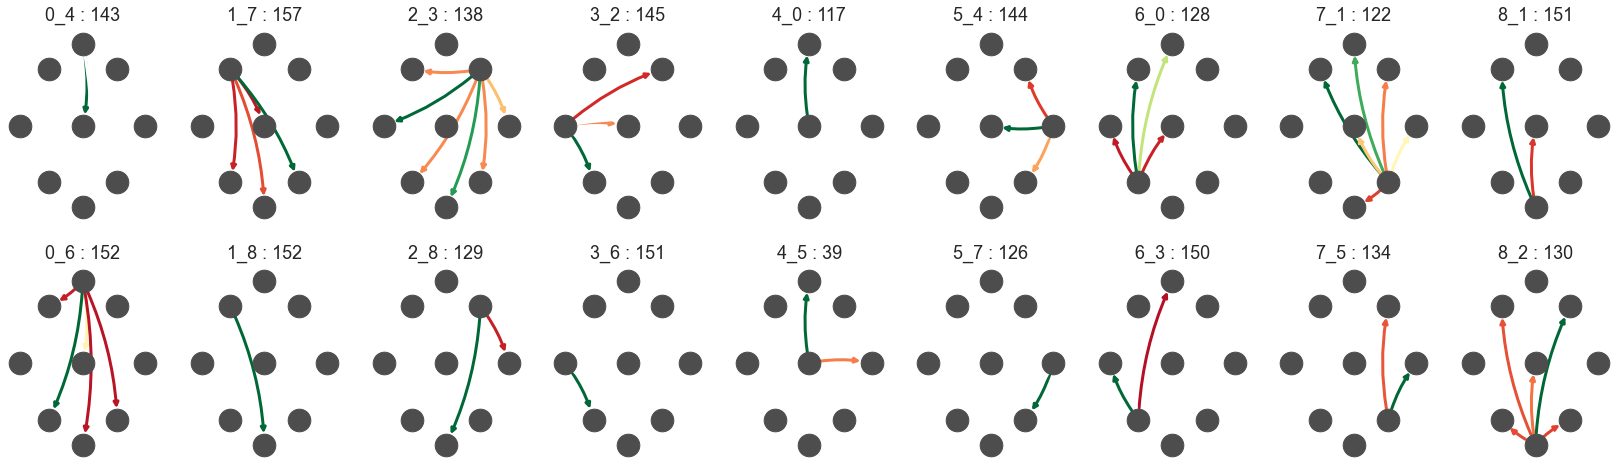




DF IS EMPTY



loop : [6, 8, 1, 0, 4, 7, 5, 2, 3] 
number of sessions: 17 
C00499495_4


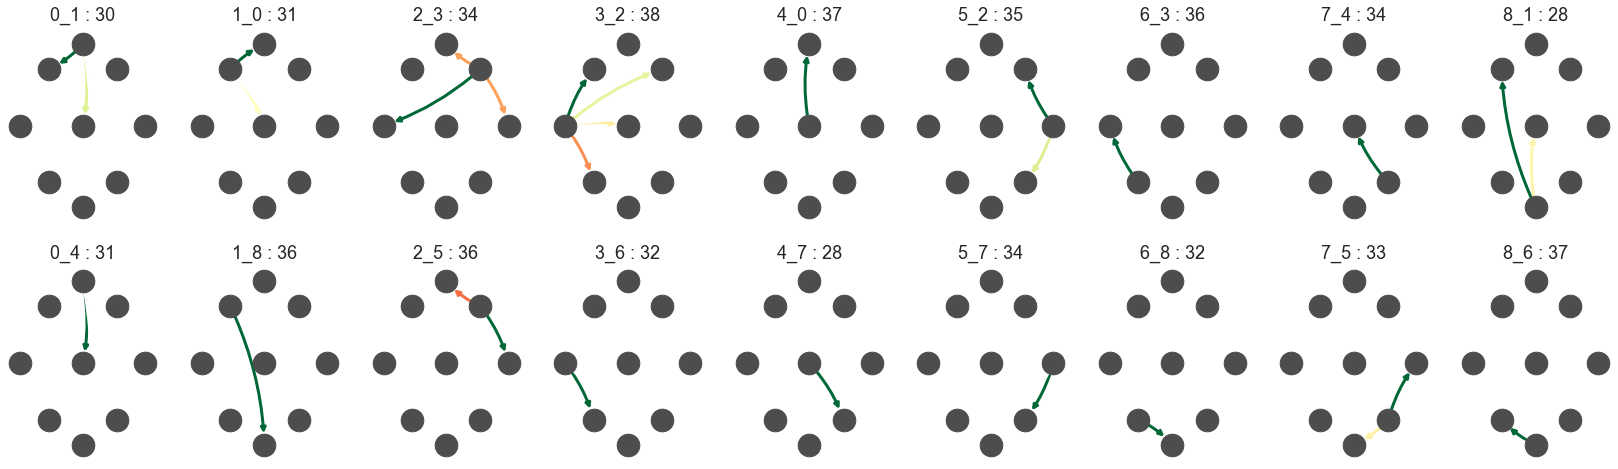




DF IS EMPTY






DF IS EMPTY





In [235]:
for subject in df['subject'].unique():
    for i in [0,1]: show_mistakes(subject,i,50,9,4)

In [ ]:
#C00494062_2 is confused between the 2 sequences


In [145]:
df['subject'].unique()

array(['C00499495_5', 'C00499495_3', 'C00499495_1', 'C00494062_3',
       'C00494062_2', 'C00499495_6', 'C00494062_1', 'C00494062_4',
       'C00499495_4', 'C00494062_5'], dtype=object)

In [164]:
subject_name='C00499495_5'
min_rew = 50
task_nr = 1
r_len_seq = 9

df[(df['n_rewards']>min_rew)\
        & (df['subject']==subject_name)\
        & (df['task_nr']==task_nr)\
        & (df['len_seq']==r_len_seq)\
        & (df['probe_dict']!={})\
        &(df['date']>(datetime.now()-timedelta(days=15)))]

,subject,exp_name,date,seq,task_nr,probe_dict,len_seq,n_rewards,graph_type,sess_dur,full_sequence,fpath,full_sequences,probe_from,probe_target,probe_to,probe_transition
6398,C00499495_5,ec_lineloop_2,2021-07-15 02:46:51,"[7, 0, 4, 5, 2, 6, 8, 1, 3]",1,"{'2_6': [False, False, False, False], '8_1': [...",9,53.0,line,NaN,NaN,/Users/joshuakeeling/Dropbox/pyhomecage/data/e...,"[[3, 6, 1, 8, 4, 5, 7, 2, 0], [7, 0, 4, 5, 2, ...","[2, 8, 0, 0, 2, 6, 1, 3, 1, 8, 6, 5, 4, 0, 7, ...","[6, 1, 7, 4, 6, 8, 3, 1, 8, 6, 2, 4, 0, 7, 0, ...","[0, 6, 7, 4, 4, 8, 6, 6, 8, 6, 2, 7, 0, 2, 5, ...","[2_6, 8_1, 0_7, 0_4, 2_6, 6_8, 1_3, 3_1, 1_8, ..."
